In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import corner
import math as math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
import pip as pip
import os
import emcee

In [3]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [5]:
if not os.path.exists("data"):
    os.mkdir("data")
    
truths = {
    "period": 5.530,
    "amplitude": 0.23,
    "phase": 2.825,
    "offset": 2.35,
    "error": 0.04,
}

# Generate the light curve
time = np.arange(0, 27, 1. / 24. / 60.)
truths["flux"] = np.sin(2 * np.pi * time / truths["period"] + truths["phase"])
truths["flux"] *= truths["amplitude"]
truths["flux"] += truths["offset"]

# Add noise
np.random.seed(11)
err = np.ones_like(truths["flux"]) * truths["error"]
flux = np.array(truths["flux"])
flux += np.random.randn(len(time)) * err

# Save
X = np.hstack((time.reshape(-1, 1), 
               flux.reshape(-1, 1), 
               err.reshape(-1, 1)))
np.savetxt("data/worksheet3.txt", X)

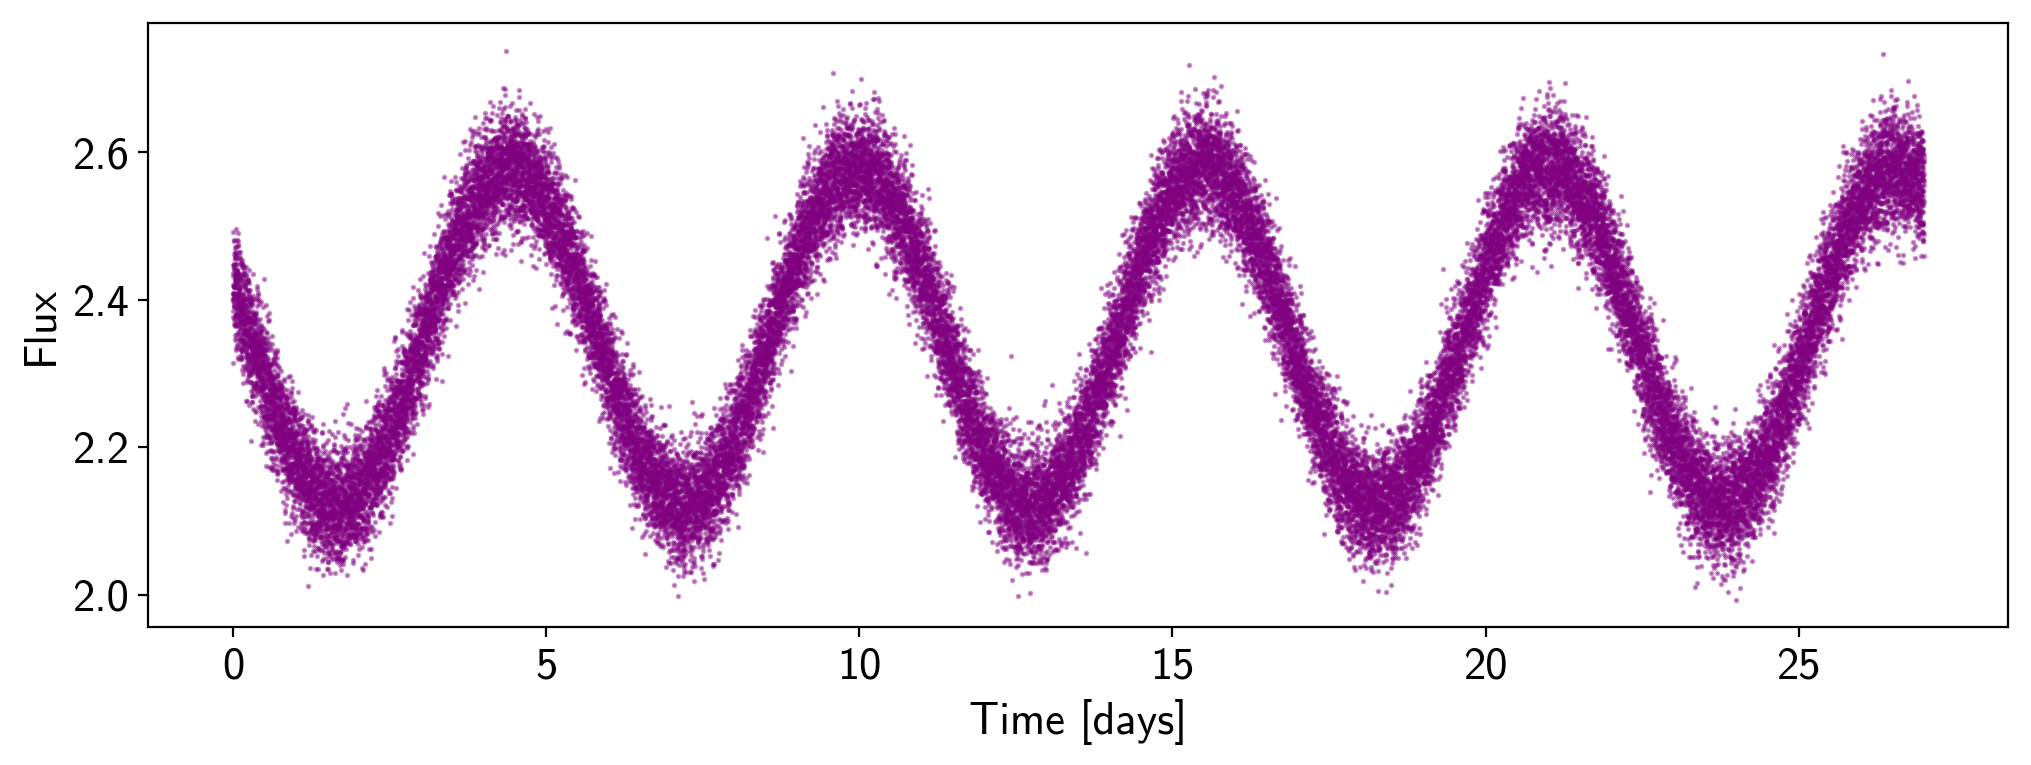

In [14]:
time, flux, err = np.loadtxt("data/worksheet3.txt").T
plt.plot(time, flux, 'k.', ms=2, alpha=0.4, color = 'purple')
plt.xlabel("Time [days]")
plt.ylabel("Flux");

In [27]:
def model(period, phase, amplitude, offset):
    return offset + amplitude * np.sin(2 * np.pi / period * time + phase)

In [28]:
def lnlike(params):
    period, phase, amplitude, offset = params
    chisq = np.sum((model(period, phase, amplitude, offset) - flux) ** 2)
    return -0.5 * chisq

In [29]:
def lnprior_period(period):
    if period < 0:
        return -np.inf
    elif period > 10:
        return -np.inf
    else:
        return 0

def lnprior_amplitude(amplitude):
    if amplitude < 0:
        return -np.inf
    elif amplitude > 1:
        return -np.inf
    else:
        return 0

def lnprior_phase(phase):
    if phase < 0:
        return -np.inf
    elif phase > 2 * np.pi:
        return -np.inf
    else:
        return 0

def lnprior_offset(offset):
    if offset < 2:
        return -np.inf
    elif offset > 3:
        return -np.inf
    else:
        return 0

In [30]:
def lnprior(params):
    period, phase, amplitude, offset = params
    return lnprior_period(period) + lnprior_amplitude(amplitude) + lnprior_phase(phase) + lnprior_offset(offset)
def lnprob(params):
    return lnprior(params) + lnlike(params)

In [36]:
nwalkers = 50
ndim = 4
mysamples = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
initial_pos = []
for i in range(nwalkers):
    period = np.random.uniform(0, 10)
    phase = np.random.uniform(0, 2 * np.pi)
    amplitude = np.random.uniform(0, 1)
    offset = np.random.uniform(2, 3)
    initial_pos.append([period, phase, amplitude, offset])
mysamples.run_mcmc(initial_pos, 500);
mysamples.chain.shape

(50, 500, 4)

In [ ]:
#number of effective samples = (number of total) / (autocorelation of time)
#mcmc will do it for you .acor - like an extension of a period to something that is not periodic

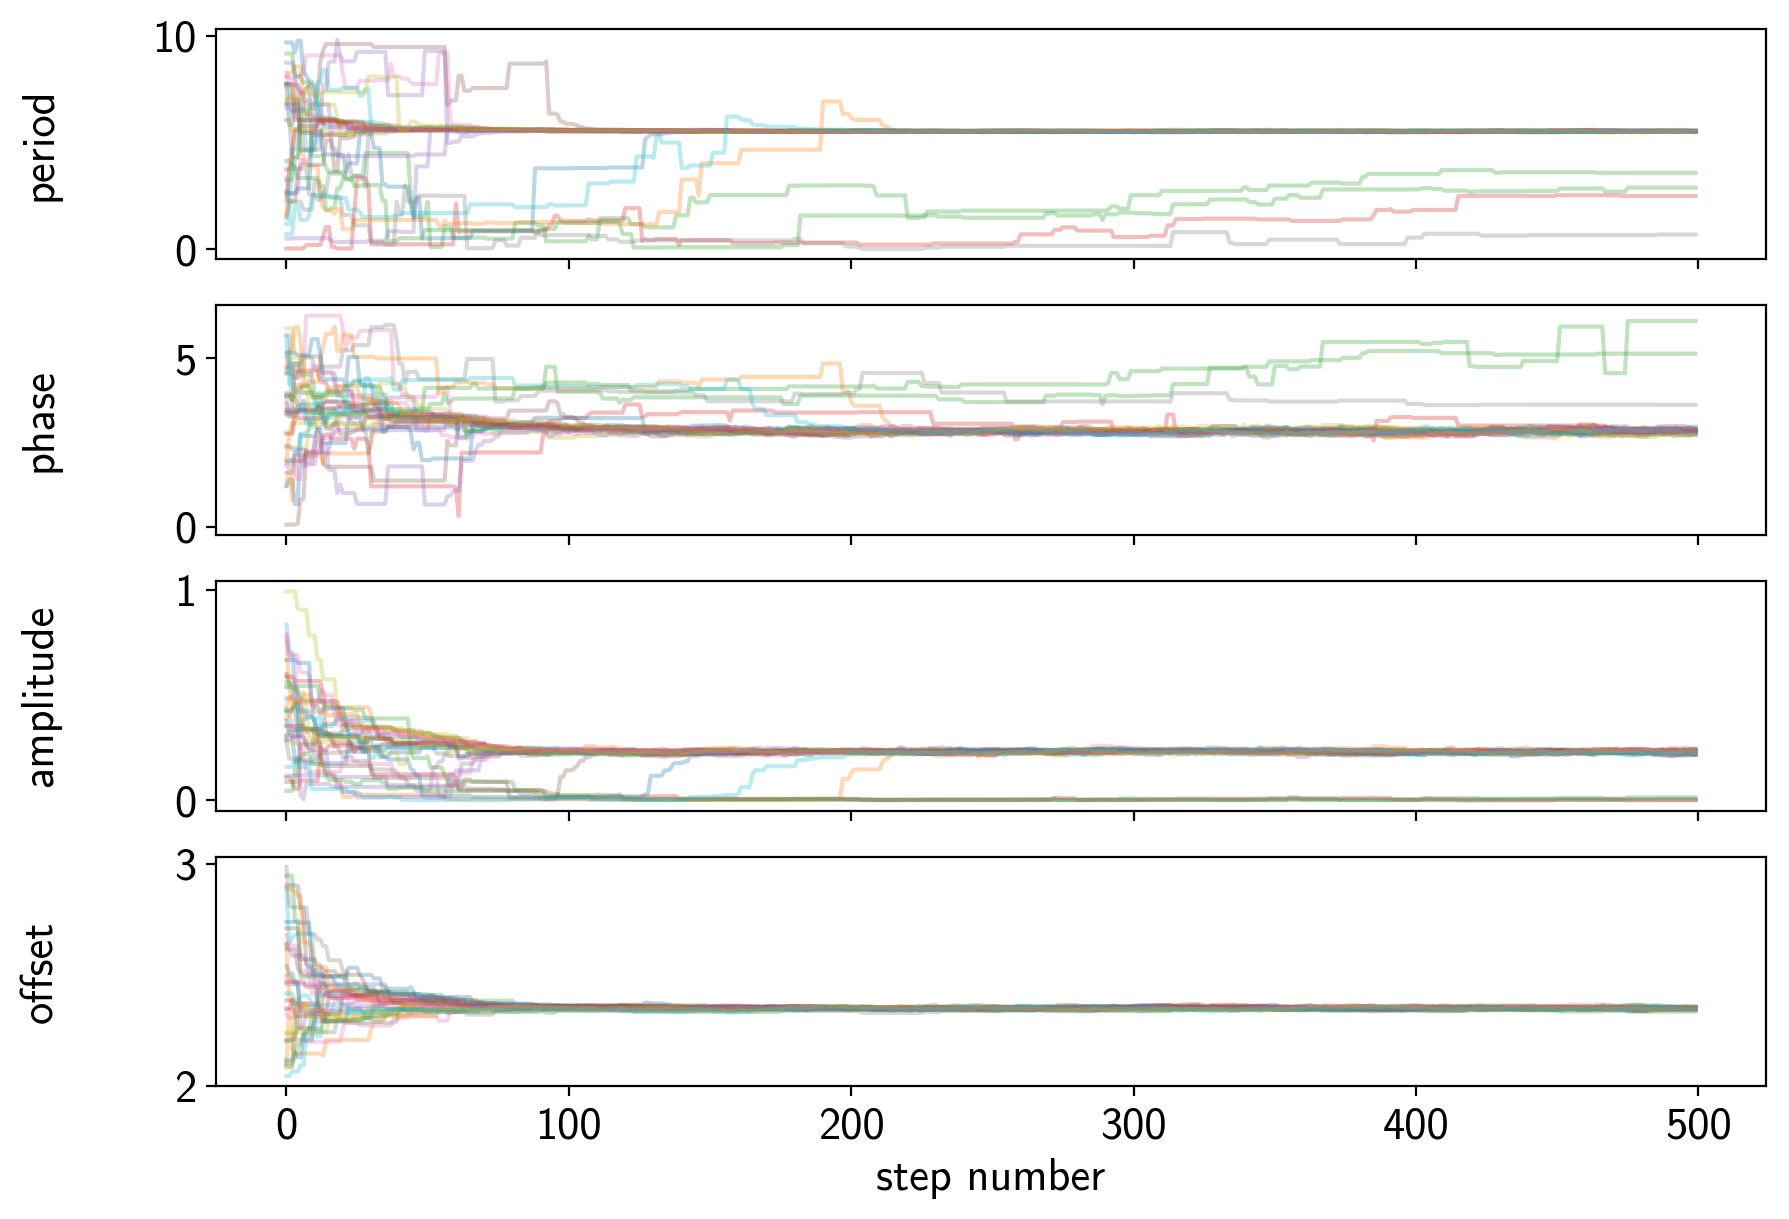

In [32]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = mysamples.chain
labels = ["period", "phase", "amplitude", "offset"]
for i in range(ndim):
    ax = axes[i]
    for k in range(nwalkers):
        ax.plot(samples[k, :, i], alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

In [46]:
median = np.median(samples, axis=(0, 1))
std = 1.4826 * np.median(np.abs(samples - median), axis=(0, 1))
initial_pos = [median + std * np.random.randn(4) for k in range(nwalkers)]
mysamples.reset()
mysamples.run_mcmc(initial_pos, 20000);

In [47]:
mysamples.chain.shape

(50, 20000, 4)

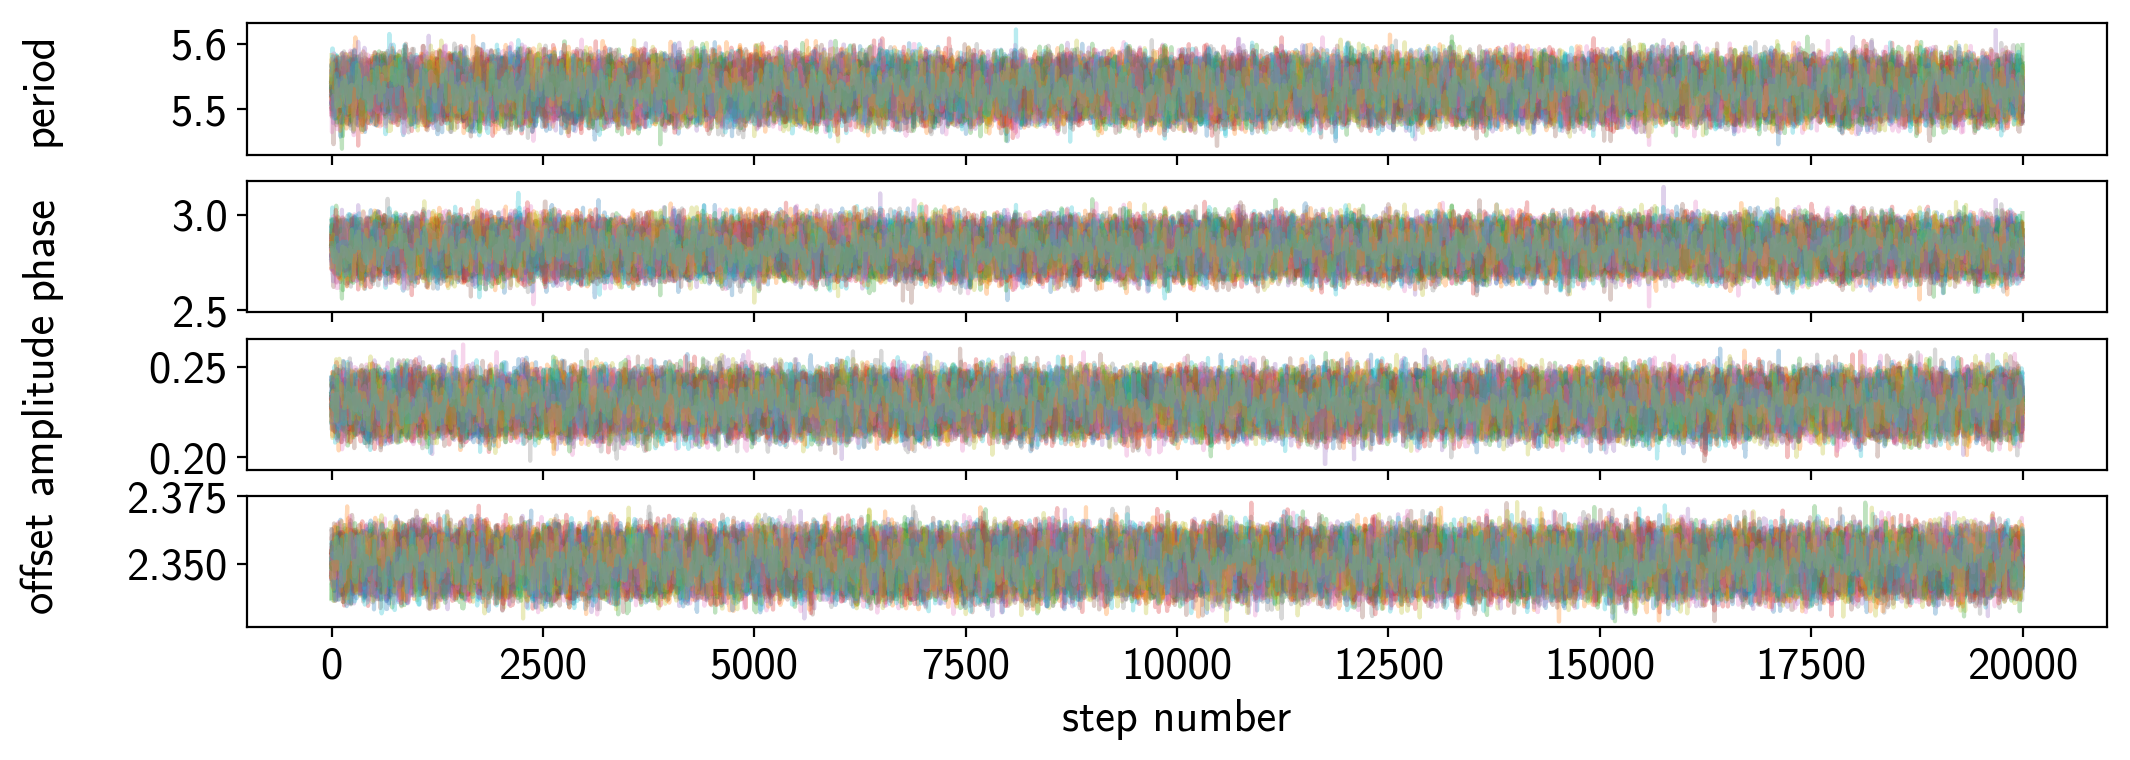

In [48]:
fig, axes = plt.subplots(4, sharex=True)
samples = mysamples.chain
labels = ["period", "phase", "amplitude", "offset"]
for i in range(ndim):
    ax = axes[i]
    for k in range(nwalkers):
        ax.plot(samples[k, :, i], alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

In [50]:
mysamples.acor
number_of_eff_steps = 100000 / mysamples.acor
print(number_of_eff_steps)

[ 1970.63476238  2119.98664005  2833.87490335  1685.43354119]


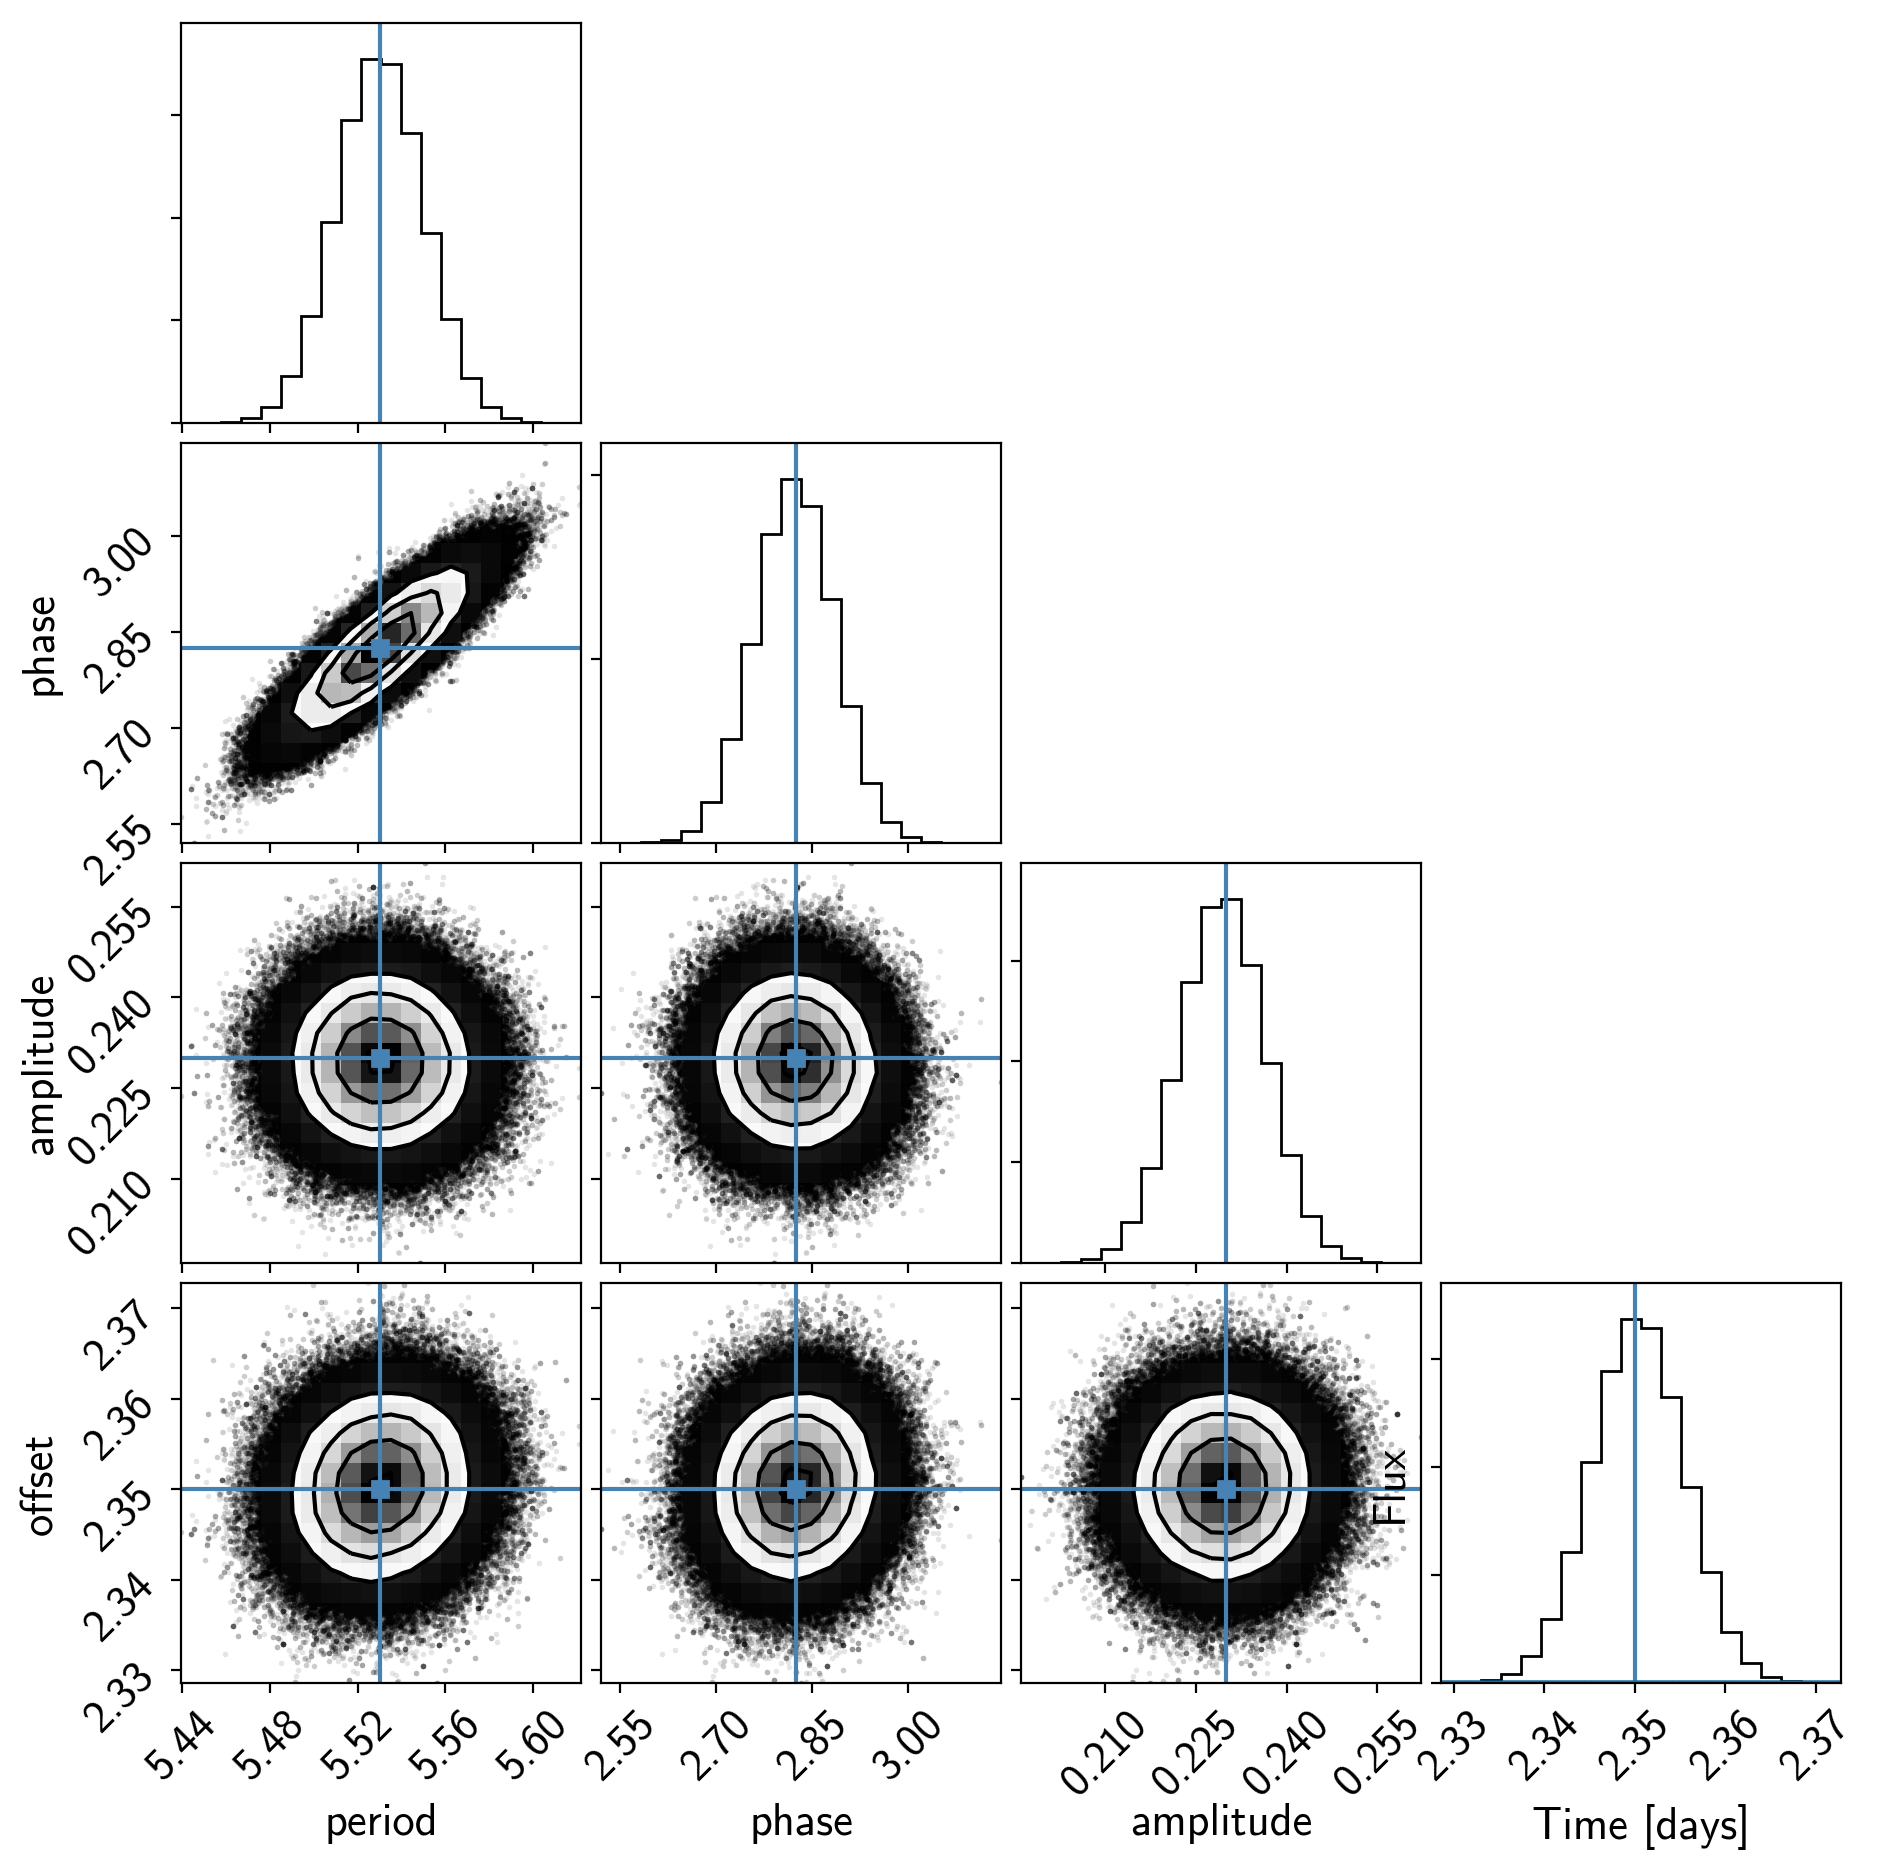

In [51]:
true_values = [truths[label] for label in labels]
flat_samples = samples.reshape(-1, 4)
fig = corner.corner(flat_samples, labels=labels, truths=true_values)
plt.plot(time, flux, 'k.', ms=2, alpha=0.3)
for i in range(50):
    idx = np.random.randint(len(flat_samples))
    plt.plot(time, model(*flat_samples[idx]), "C0", alpha=0.3)
plt.xlabel("Time [days]")
plt.ylabel("Flux");